# Лабораторная работа 2. Оптимальные портфели инвистиций

### Выполнили: Артамонов Денис, Железцова Ирина, Зарубина Маргарита 16ПМИ

#### Результаты работы
- На основе своего отнешения к риску построены оптимальные портфели
- Построены портфели из 10 активов, дана оценка оптимального портфеля
- Построен оптимальный рыночный портфель
- Дана характеристика выбранного индекса
- Осуществлена попытка подбора коэфициентов для построение модели с одним индексом

Данные были взяты из Домашней работы №1. 

In [2]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import finance_scripts as fs
from scipy.optimize import minimize
import importlib


In [3]:
# fs.init()
importlib.reload(fs)

<module 'finance_scripts' from 'C:\\Users\\Ирина\\Finance\\finance_scripts.py'>

После загрузки мы получили таблицу цен закрытия и дневных объёмов продаж:

In [4]:
dClosed = pd.read_pickle("close_cleared.pickle") #  цены закрытия
dVolume = pd.read_pickle("volume_cleared.pickle") #  объёмы продаж

Число исследуемых компаний:

In [5]:
print(dClosed.shape[1]) # Число исследуемых компаний

72


Рассчитаем логарифмическую доходность загруженных активов:

In [7]:
logR = np.log(dClosed / dClosed.shift(1))
e = datetime.strptime('2017-01-02', '%Y-%m-%d')
logR = logR.drop(e)

## 1. Построение своего личного оптимального портфеля инвестиций из 50 активов.

Берем первые 50 активов для построения портфеля инвестиций.

In [8]:
portfolio_num = 50
portfolio_stocks = logR.columns[:portfolio_num]
portfolio_R=logR[portfolio_stocks]

Построим карту выбранных активов:

In [9]:
chosen_logR = logR[portfolio_stocks]
chosen_volume = dVolume[portfolio_stocks]

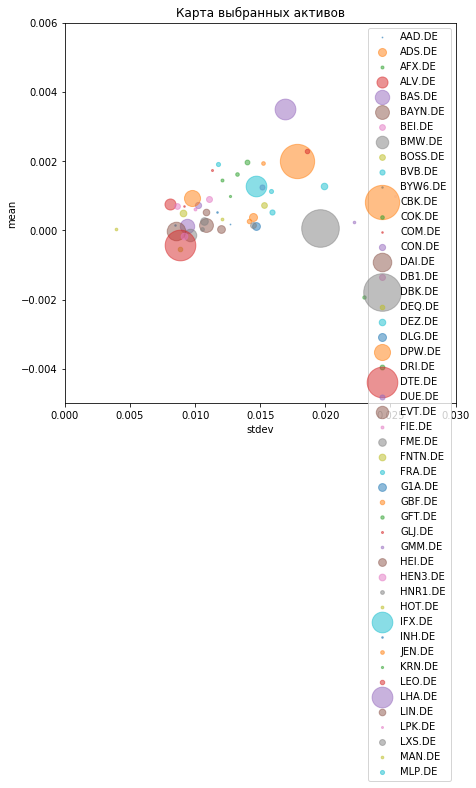

In [10]:
plt.rcParams["figure.figsize"] = (7,7)
fig, ax = plt.subplots()
for stock in portfolio_stocks:
    ax.scatter(chosen_logR[stock].std(), chosen_logR[stock].mean(), 
                   s=dVolume[stock].mean()/10000, label=stock, alpha=0.5)
plt.title("Карта выбранных активов")
plt.xlabel("stdev")
plt.ylabel("mean")
plt.xlim(0,0.03)
plt.ylim(-0.005, 0.006)
ax.legend()
plt.show()

Функция random_portfolio() для генерации случайного портфеля, возвращает среднее значение доходности и стандартное отклонение доходности  𝜎 портфеля.

Среднее значение расчитывается как взвешенное средних активов, входящий в портфель: 
$\mu=p^\intercal x$, где 
- $x = (x_1, ..., x_n)$ - вектор весов, полученный с помощью функции rand_weights()
- $p$ - вектор средних доходностей активов в портфеле

Стандартное отклонение расчитывается как $\sigma=\sqrt{x^\intercal Cx}$, где
- $C$ - ковариационная матрица доходностей

In [11]:
mu, sigma = fs.random_portfolio(portfolio_R)
print(f'mu = {mu}, sigma = {sigma}')

mu = 0.0007701991998108891, sigma = 0.006341263884715245


Построим 10000 случайных портфелей и посмотрим их расположение на карте активов.

In [12]:
n_portfolios = 10000
means, stds = np.column_stack([  
    fs.random_portfolio(portfolio_R) for _ in range(n_portfolios)
])

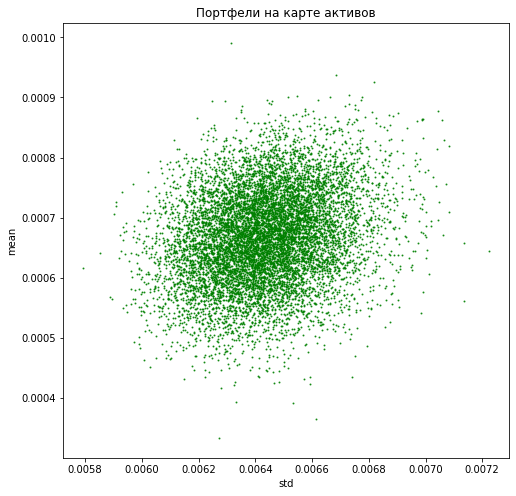

In [13]:
plt.rcParams["figure.figsize"] = (8,8)
plt.plot(stds, means, 'o', markersize=1, alpha=0.8, color='g')  
plt.xlabel('std')  
plt.ylabel('mean')  
plt.title('Портфели на карте активов')  
plt.show()

## Эффективный портфель

### с запретом коротких продаж

Построим эффективный портфель с запретом коротких продаж.

$u(\sigma, E) = E-\gamma\sigma \rightarrow max$ - utility function

Из обоснования мы получили, что решение задачи с соответствующим $\gamma$ будет соответствовать точке на эффективном фронте. При этом меняя $-\infty < \gamma < \infty$ мы получим все точки эффетивного фронта. Коэффициент $\gamma$ отвечает за наше отношение к риску, чем меньше - тем положительнее мы к нему относимся. Нами были выбраны разные значения $\gamma$ и эфективные портфели при данных значениях указаны на графике.

In [14]:
R_mean = np.mean(portfolio_R, axis=0).values 
C = np.cov(portfolio_R.values.T)
target_R = np.arange(-0.0001,0.0035,0.0001)
efficient_portfolios_sol = fs.efficient_frontier(R_mean, C, target_R, short_terms=False)

In [15]:
gms = [0.1, 0.5, 1]
opts, xs= fs.optimal_portfolios(R_mean, C, gms)

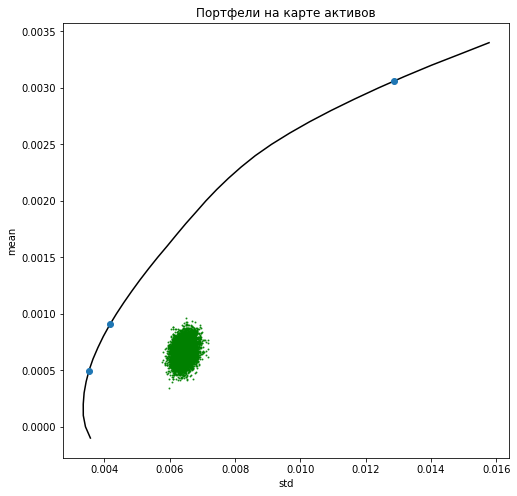

In [16]:
n_portfolios = 10000
means, stds = np.column_stack([  
    fs.random_portfolio(portfolio_R) for _ in range(n_portfolios)
])
plt.plot(stds, means, 'o', markersize=1, alpha=0.8, color='g') 

plt.plot(  efficient_portfolios_sol.T[0], efficient_portfolios_sol.T[1], linestyle='-', color='black', label='efficient frontier')
plt.plot(  opts.T[0], opts.T[1], 'o', label='optimal portfolio')
plt.xlabel('std')  
plt.ylabel('mean')  
plt.title('Портфели на карте активов')  
plt.show()

## Характеристика портфеля по составу 

Рассмотрим портфель с $\gamma =1$. Посмотрим на веса с которыми входит каждая из акций в эффективный портфель.  

In [37]:
xs[2]

array([1.07350137e-02, 0.00000000e+00, 3.41976937e-02, 1.08420217e-17,
       0.00000000e+00, 1.80248611e-18, 2.22626079e-02, 0.00000000e+00,
       1.59707244e-02, 0.00000000e+00, 6.20599780e-02, 1.32814766e-18,
       0.00000000e+00, 9.70716342e-02, 4.12952252e-03, 6.40356908e-19,
       3.35873687e-02, 0.00000000e+00, 0.00000000e+00, 1.18923426e-18,
       0.00000000e+00, 3.92684474e-18, 2.07899801e-03, 1.51788304e-18,
       3.87602277e-18, 8.64602768e-03, 2.12299985e-02, 5.62429877e-19,
       3.82957831e-02, 5.93175163e-02, 1.13841228e-18, 3.76760255e-18,
       0.00000000e+00, 1.61715312e-02, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 4.77048956e-18, 4.60785923e-19,
       1.65340831e-18, 1.58903381e-18, 0.00000000e+00, 2.84603070e-18,
       2.48607495e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       5.49384853e-01, 1.15535294e-18])

Больше половины портфеля (5.49384853e-01) составляет MAN. Около $1/10$ портфеля занимают активы comdirect bank Aktiengesellschaft(9.70716342e-02), это второй по величине вхождения актив. 

Наименьший вес в портфеля занимают акции компаний Infineon Technologies AG (4.60785923e-19) и Fresenius Medical Care AG & Co (5.624298769768554e-19).

Около половины активов не участвуют в формирование портфеля.

## VaR

$Var_\alpha = -E + u_{1-\alpha} \sigma$

для $\alpha = 0.05$: $u_{0.95} = 1.65$

In [39]:
E, std = opts[2]

In [40]:
u = 1.65
Var = -E + u*std

In [41]:
Var

-0.0027055060720599516

VaR говорит нам о том, что с вероятностью 95% наш доход будет больше -0.0027. Если округлить значение, то мы можем сказать, что наш доход по оптимальному портфелю с 95% вероятностью не даст отрицательного дохода.

### с разрешением коротких продаж

In [46]:
R_mean_st = np.mean(portfolio_R, axis=0).values 
C_st = np.cov(portfolio_R.values.T)
target_R_st = np.arange(-0.0001,0.0035,0.0001)
efficient_portfolios_sol_st = fs.efficient_frontier(R_mean_st, C_st, target_R_st, short_terms=True)

In [47]:
gms_st = [0.1, 0.5, 1]
opts_st, xs_st = fs.optimal_portfolios(R_mean_st, C_st, gms_st)

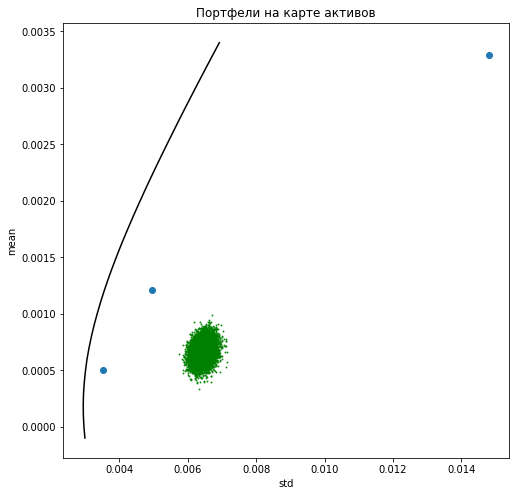

In [48]:
n_portfolios = 10000
means_st, stds_st = np.column_stack([  
    fs.random_portfolio(portfolio_R) for _ in range(n_portfolios)
])
plt.plot(stds_st, means_st, 'o', markersize=1, alpha=0.8, color='g') 

plt.plot(  efficient_portfolios_sol_st.T[0], efficient_portfolios_sol_st.T[1], linestyle='-', color='black', label='efficient frontier')
plt.plot(  opts_st.T[0], opts_st.T[1], 'o', label='optimal portfolio')
plt.xlabel('std')  
plt.ylabel('mean')  
plt.title('Портфели на карте активов')  
plt.show()

## Характеристика портфеля по составу 

Также рассмотрим портфель с $\gamma =0.1$. Посмотрим на веса с которыми входит каждая из акций в эффективный портфель с разрешением коротких продаж.  

In [54]:
xs_st[0]

array([1.73429782e-18, 9.33116865e-19, 0.00000000e+00, 0.00000000e+00,
       1.45805192e-17, 5.19900428e-18, 0.00000000e+00, 1.34902443e-17,
       5.62346891e-18, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.84912036e-17, 2.04370385e-17,
       0.00000000e+00, 0.00000000e+00, 4.81982931e-18, 0.00000000e+00,
       1.27439374e-17, 0.00000000e+00, 2.91214481e-02, 1.93081817e-17,
       0.00000000e+00, 1.62206963e-02, 0.00000000e+00, 1.54151033e-17,
       1.09466883e-17, 1.02137184e-01, 5.84708725e-18, 9.05441312e-18,
       5.81634655e-18, 0.00000000e+00, 4.54598502e-18, 2.05246301e-17,
       1.47444883e-18, 8.35947303e-18, 0.00000000e+00, 3.47207998e-18,
       3.81840979e-18, 0.00000000e+00, 0.00000000e+00, 4.41434891e-17,
       8.52520671e-01, 0.00000000e+00, 0.00000000e+00, 7.74560287e-18,
       6.75173131e-19, 0.00000000e+00])

In [59]:
portfolio_stocks[1]

'ADS.DE'

При разрешение коротких продаж большая часть (8.52520671e-01) эффективного портфеля состоит из акций "Lufthansa", еще чуть больше $1/10$ занимают активы аэропорта Франкфурт (1.02137184e-01).

Если посмотреть на минималные по весу вхождения акции, то это будут MAN с весом 6.75173131e-19 и adidas (9.33116865e-19). 

## VaR

$Var_\alpha = -E + u_{1-\alpha} \sigma$

для $\alpha = 0.05$: $u_{0.95} = 1.65$

In [60]:
E_st, std_st = opts[0]

In [61]:
u = 1.65
Var_st = -E_st + u*std

In [62]:
Var_st

-0.01205763690360233

VaR говорит нам о том, что с вероятностью 95% наш доход будет больше -0.012. Если округлить значение, то мы можем сказать, что наш доход по оптимальному портфелю с 95% вероятностью не даст отрицательного дохода.

## Сравнение портфелей 

 При построение портфелей с разрешение и запретом коротких продаж наибольший вклад вносили акции разных компаний. При запрете коротких продаж это MAN, а при разрешении на короткие продажи это акций авиакомпании "Lufthansa". Наименьший вклад внесли разные компании. Интересно, что акции MAN, которые имеют наибольший вес при формировании портфеля с запретом на короткие продажи, вошли в портфель с короткими продажами с маленьким весом.  

## 2. Построение оптимального портфеля инвестиций из 10 активов.

Для построения портфеля из 10 акций мы взяли первые по списку.

In [63]:
portfolio_num_2 = 10
portfolio_stocks_2 = logR.columns[:portfolio_num_2]
portfolio_R_2=logR[portfolio_stocks_2]

In [64]:
chosen_logR_2 = logR[portfolio_stocks_2]
chosen_volume_2 = dVolume[portfolio_stocks_2]

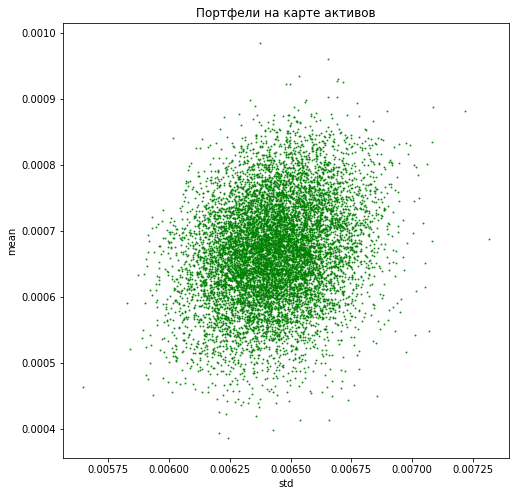

In [65]:
n_portfolios = 10000
means_2, stds_2 = np.column_stack([  
    fs.random_portfolio(portfolio_R) for _ in range(n_portfolios)
])
plt.rcParams["figure.figsize"] = (8,8)
plt.plot(stds_2, means_2, 'o', markersize=1, alpha=0.8, color='g')  
plt.xlabel('std')  
plt.ylabel('mean')  
plt.title('Портфели на карте активов')  
plt.show()

## Эффективный портфель

### с запретом коротких продаж

In [66]:
R_mean_2 = np.mean(portfolio_R_2, axis=0).values 
C_2 = np.cov(portfolio_R_2.values.T)
target_R_2 = np.arange(-0.0001,0.0035,0.0001)
efficient_portfolios_sol_2 = fs.efficient_frontier(R_mean_2, C_2, target_R_2, short_terms=False)

In [67]:
gms_2 = [0.1, 0.5, 1]
opts_2, xs_2= fs.optimal_portfolios(R_mean_2, C_2, gms_2)

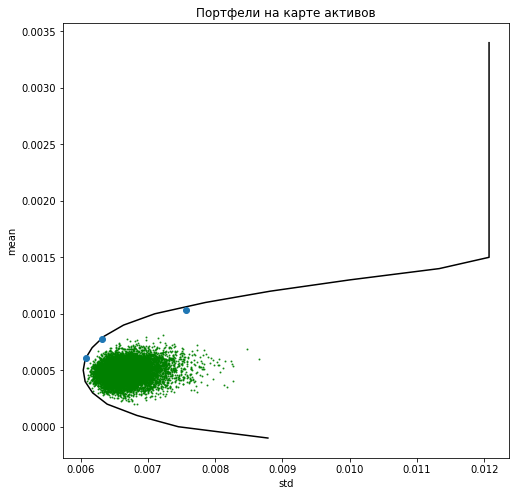

In [68]:
n_portfolios = 10000
means_2, stds_2 = np.column_stack([  
    fs.random_portfolio(portfolio_R_2) for _ in range(n_portfolios)
])
plt.plot(stds_2, means_2, 'o', markersize=1, alpha=0.8, color='g') 

plt.plot(  efficient_portfolios_sol_2.T[0], efficient_portfolios_sol_2.T[1], linestyle='-', color='black', label='efficient frontier')
plt.plot(  opts_2.T[0], opts_2.T[1], 'o', label='optimal portfolio')
plt.xlabel('std')  
plt.ylabel('mean')  
plt.title('Портфели на карте активов')  
plt.show()

## Характеристика портфеля по составу 

Рассмотрим портфель с $\gamma =1$. Посмотрим на веса с которыми входит каждая из акций в эффективный портфель.  

In [69]:
xs_2[2]

array([0.12083671, 0.00988971, 0.08994647, 0.24460711, 0.00850099,
       0.03650272, 0.26620689, 0.09591851, 0.07874522, 0.04884568])

In [73]:
portfolio_stocks[4]

'BAS.DE'

При построении портфеля из 10 активов веса распределились равномернее. Наибольший вклад вноситят акции Beiersdorf Aktiengesellschaft и вес равен 0.26620689. Второе место по величине веса занимают акций Allianz SE c весом 0.24460711.  

В эффективный портфель из 10 акций нет активом, которые вошли бы с 0 весом. Наименьший вклад из входящих в портффель акций составили активы Adidas (0.00988971) и BASF SE NA O.N (0.00850099).  

## VaR

In [75]:
E_2, std_2 = opts_2[2]

In [76]:
u = 1.65
Var_2 = -E + u*std

In [77]:
Var_2

-0.0027055060720599516

Для 10 активов значение VaR для оптимального портфеля с запретом коротких продаж значительно не поменялось. Можем ли мы говорить о том, что состав не поменялся?

### с разрешением коротких продаж

In [78]:
R_mean_st_2 = np.mean(portfolio_R_2, axis=0).values 
C_st_2 = np.cov(portfolio_R_2.values.T)
target_R_st_2 = np.arange(-0.0001,0.0035,0.0001)
efficient_portfolios_sol_st_2 = fs.efficient_frontier(R_mean_2, C_2, target_R_2, short_terms=True)

In [79]:
gms_st_2 = [0.1, 0.5, 1]
opts_st_2, xs_st_2 = fs.optimal_portfolios(R_mean_2, C_2, gms)

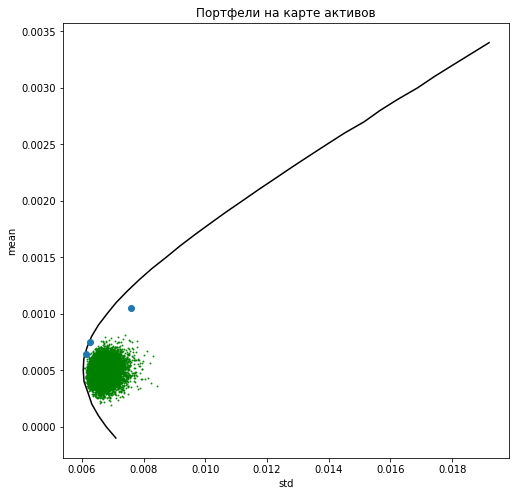

In [80]:
n_portfolios = 10000
means_st_2, stds_st_2 = np.column_stack([  
    fs.random_portfolio(portfolio_R_2) for _ in range(n_portfolios)
])
plt.plot(stds_st_2, means_st_2, 'o', markersize=1, alpha=0.8, color='g') 

plt.plot(  efficient_portfolios_sol_st_2.T[0], efficient_portfolios_sol_st_2.T[1], linestyle='-', color='black', label='efficient frontier')
plt.plot(  opts_st_2.T[0], opts_st_2.T[1], 'o', label='optimal portfolio')
plt.xlabel('std')  
plt.ylabel('mean')  
plt.title('Портфели на карте активов')  
plt.show()

## Характеристика портфеля по составу 

Также рассмотрим портфель с $\gamma =0$. Посмотрим на веса с которыми входит каждая из акций в эффективный портфель с разрешением коротких продаж.  

In [81]:
xs_st_2[0]

array([2.25514052e-17, 0.00000000e+00, 4.40164933e-01, 2.09248736e-01,
       0.00000000e+00, 0.00000000e+00, 1.90722395e-01, 0.00000000e+00,
       1.59863936e-01, 0.00000000e+00])

При разрешении коротких продаж также не появилось активов с отрицательными весами. Чуть больше чем на 44% портфель состоит из акций Carl Zeiss Meditec AG (4.40164933e-01), еще около 21% принадлежит  Allianz SE (2.09248736e-01).

В портфель с разрешением коротких продаж не вошли акции компаний: Adidas, BASF SE NA, BAYN, BMW, BVB. С наименьшим весом в формировании портфеля участвую акции компании Amadeus FiRe AG (2.25514052e-17) и BOSS (1.59863936e-01).

## VaR

$Var_\alpha = -E + u_{1-\alpha} \sigma$

для $\alpha = 0.05$: $u_{0.95} = 1.65$

In [94]:
E_st_2, std_st_2 = opts_st_2[0]

In [95]:
u = 1.65
Var_st_2 = -E + u*std

In [96]:
Var_st_2

-0.0027055060720599516

Показатель VaR не изменил своего значения.

## Сравнение портфелей 

Если сравнивать порфели с разрешением на запрет и разрешение коротких продаж, то можно заметить, что основной вклад также вносят разные компании. При построении портфеля с короткими продажами половина акций имеет нулевой вес. Интересно,что VaR не изменился как при разрешении и запрете коротких продаж, так и при смене числа акций участвующих в его формировании.   

## Задание 3

Рассмотрите набор активов, отобранных в п.2 (10 активов).  Выберете  безрисковый актив (можно виртуальный). Постройте оптимальный (рыночный)  портфель. Сделайте анализ долей активов рыночного портфеля. Оцените VaR доходностей портфеля. Рассмотрите два случая: 
- короткие продажи разрешены, 
- короткие продажи запрещены.

В качестве безрискового актива положим виртуальный актив с нулевым отклонением и доходностю $E_f = 0.0001$.

Оптимальный портфель можно посторить максимизируя коэффициент Шарпа:
$$
\frac{E-E_f}{\sigma} \rightarrow max ,
\\
s.t. \sum{x_i}=1, \; x_i>0 \text{ (при запрете коротких продаж)}
$$

Функция *make_opt_portfolio_by_sharpe_ratio()* минимизирует противоположную функцию. Таким образом мы получаем вектор $x=(x_1,...,x_n)$ долей активов, которым задаётся портфель.

#### Короткие продажи запрещены

In [114]:
portfolio_num = 10
portfolio_stocks = logR.columns[:portfolio_num]
portfolio_R=logR[portfolio_stocks]

In [115]:
assets_num = 10 # выбираем 10 активов, которые войдут в портфель
chosen_stocks = logR.columns[:portfolio_num]
assets_R=logR[portfolio_stocks]

In [116]:
R_mean = np.mean(assets_R, axis=0).values 
C = np.cov(assets_R.values.T)

In [117]:
target_R = np.arange(-0.00015,0.0015,0.0001)
efficient_portfolios = fs.efficient_frontier(R_mean, C, target_R, short_terms=False) # строим эффективный фронт портфелей по выбранным активам

In [118]:
Ef = 0.0001
max_sharpe = fs.make_opt_portfolio_by_sharpe_ratio(R_mean, C, Ef, short_terms=False) # вычисляем оптимальный портфель
r_sharp,std_sharp  = fs.portfolio_performance(max_sharpe.x, R_mean, C)

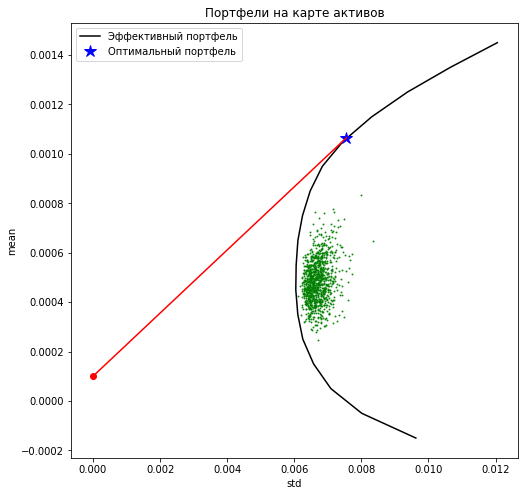

In [119]:
n_portfolios = 1000
means, stds = np.column_stack([  
    fs.random_portfolio(portfolio_R) for _ in range(n_portfolios)
])

plt.plot(stds, means, 'o', markersize=1, alpha=0.8, color='g') 
plt.plot(  efficient_portfolios.T[0], efficient_portfolios.T[1], linestyle='-', color='black', label='Эффективный портфель')
plt.plot(std_sharp, r_sharp, 'b*',markersize=12, label='Оптимальный портфель') 
plt.scatter(0,Ef, c='r')
plt.plot( [0,std_sharp], [Ef, r_sharp],linestyle='-', color='r',)
plt.xlabel('std')  
plt.ylabel('mean')  
plt.legend()
plt.title('Портфели на карте активов')  
plt.show()

In [120]:
print(f'Характиристики оптимального портфеля:\n')
print(f'Доходность: {r_sharp}\nОтклонение: {std_sharp}\nVar: {fs.VaR(r_sharp,std_sharp)}')

Характиристики оптимального портфеля:

Доходность: 0.0010655341250894426
Отклонение: 0.0075552544220500555
Var: 0.011400635671293149


In [121]:
print('Доли активов в оптимальном портфеле:')
{stock:x for stock,x in np.column_stack([chosen_stocks, max_sharpe.x])}

Доли активов в оптимальном портфеле:


{'AAD.DE': 9.987812414396922e-18,
 'ADS.DE': 0.0,
 'AFX.DE': 0.44785845099490695,
 'ALV.DE': 0.35472453505391777,
 'BAS.DE': 0.0,
 'BAYN.DE': 8.911770800757863e-18,
 'BEI.DE': 0.11591741302337147,
 'BMW.DE': 3.3921096318634773e-17,
 'BOSS.DE': 0.08149960092780364,
 'BVB.DE': 2.5616365406367445e-18}

#### Короткие продажи разрешены

In [122]:
target_R = np.arange(-0.001,0.005,0.0001)
max_sharpe = fs.make_opt_portfolio_by_sharpe_ratio(R_mean, C, Ef, short_terms=True)
r_sharp,std_sharp  = fs.portfolio_performance(max_sharpe.x, R_mean,C)
efficient_portfolios = fs.efficient_frontier(R_mean, C, target_R, short_terms=True)


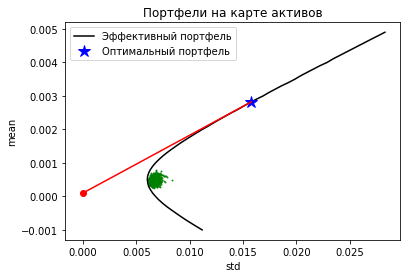

In [25]:
n_portfolios = 1000
means, stds = np.column_stack([  
    fs.random_portfolio(portfolio_R) for _ in range(n_portfolios)
])

plt.plot(stds, means, 'o', markersize=1, alpha=0.8, color='g') 
plt.plot( efficient_portfolios.T[0], efficient_portfolios.T[1], linestyle='-', color='black', label='Эффективный портфель')
plt.plot(std_sharp, r_sharp, 'b*',markersize=12, label='Оптимальный портфель') 
plt.scatter(0,Ef, c='r')
plt.plot( [0,std_sharp], [Ef, r_sharp],linestyle='-', color='r',)
plt.xlabel('std')  
plt.ylabel('mean')  
plt.legend()
plt.title('Портфели на карте активов')  
plt.show()

In [26]:
print(f'Характиристики оптимального портфеля:\n')
print(f'Доходность: {r_sharp}\nОтклонение: {std_sharp}\nVar: {fs.VaR(r_sharp,std_sharp)}')

Характиристики оптимального портфеля:

Доходность: 0.002820088469432153
Отклонение: 0.015759613078267443
Var: 0.023183273109709128


In [27]:
print('Доли активов в оптимальном портфеле:')
{stock:x for stock,x in np.column_stack([chosen_stocks, max_sharpe.x])}

Доли активов в оптимальном портфеле:


{'AAD.DE': -0.2364265635064712,
 'ADS.DE': -0.14434424345136276,
 'AFX.DE': 0.9203434570809378,
 'ALV.DE': 1.5962248769724263,
 'BAS.DE': -0.7903890931230005,
 'BAYN.DE': -0.1804772681005918,
 'BEI.DE': 0.3548805696496505,
 'BMW.DE': -0.6972689618901083,
 'BOSS.DE': 0.19131470699280956,
 'BVB.DE': -0.013857480624289686}

Продаём то, что меньше всего покупали в прошлый раз

#### Характиристика портфелей.

Если сравнивать портфели между собой, то макимальный вклад в формировании портфеля с запретом коротких продаж принадлежит компаниям BOSS (0.08149960140338222) и Carl Zeiss Meditec AG (0.44785845239738453), с разршением на короткие продажи это компании Allianz SE (1.5962248769724263) и Carl Zeiss Meditec AG (0.9203434570809378). Вторая по значимости компания совпадает в обоих случаях. 

Минимальный вклад с запретом коротких продаж вносит компания Bayer Aktiengesellschaft (2.8557086581684132e-18) и BVB.DE (9.119518837112176e-18). 

При разрешении коротких продаж наименее значимыми в формирование портфеля оказываются компании BVB.DE(-0.013857480624289686) и adidas (-0.14434424345136276).

## 4. Индекс рынка

В качестве индекса для наших данных мы взяли DAX (важнейший фондовый индекс Германии, вычисляется как среднее взвешенное по капитализации значение цен акций крупнейших акционерных компаний Германии)
Список 11-ти первых компаний из 30-ти по долям "вложений" в индекс:
- Siemens	Машиностроение	SIE	8.9866
- SAP Программное обеспечение	SAP	8.9800
- Bayer	Химическая промышленность	BAYN	8.3973
- Allianz	Страхование	ALV	8.3724
- BASF	Химическая промышленность	BAS	8.2032
- Daimler	Автомобильная промышленность	DAI	6.7480
- Deutsche Telekom	Телекоммуникации	DTE	4.6638
- Deutsche Post	Логистика	DPW	3.5570
- Промышленное газоснабжение	LIN	3.2388
- Adidas	Oдежда и обувь	ADS	3.0056


Загружаем данные по DAX и чистим их

In [170]:
DAX_data=pd.read_csv('DAX.csv', delimiter=',')
DAX_close=[]
DAX_logR=[]
for i in range(len(DAX_data["Цена"])):
    a=DAX_data["Цена"][i].replace(".","")
    a=a.replace(",",".")
    DAX_close.append(float(a))
for i in range(len(DAX_close)-1):
    DAX_logR.append(round(np.log(float(DAX_close[::-1][i])/float(DAX_close[::-1][i+1])),5))


Построим гистограмму логарифмических доходностей. Она очень напоминает нормальное распределение.

<function matplotlib.pyplot.show(*args, **kw)>

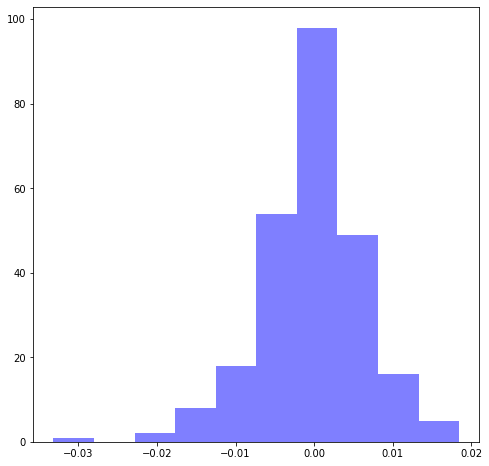

In [171]:
n, bins, patches = plt.hist(DAX_logR, 10, facecolor='blue', alpha=0.5)
plt.show

Гистограмма цен на момент закрытия (ниже)

<function matplotlib.pyplot.show(*args, **kw)>

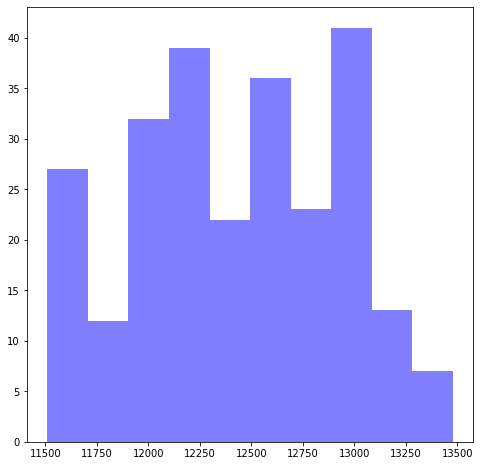

In [172]:
n, bins, patches = plt.hist(DAX_close, 10, facecolor='blue', alpha=0.5)
plt.show

Проведем Тест Хи2 на проверку гипотезы о нормальном распределении. Суть теста описана в домашней работе 1.

In [173]:
def Hi2(data,n):
    a=min(data)
    b=max(data)
    
    h=(b-a)/n
    x_i=[]
    n_i=[]
    for i in range(n):
        x_i.append(round(a+h*i,5))
        n_i.append(0)
    for i in range(1,len(data)):
        num=0
        flag=0
        for j in range(len(x_i)):
        
            if data[i]>x_i[j]:
                num+=1
            if data[i]<x_i[j] and flag==0:
                n_i[num-1]+=1
                flag=1
                continue
    x_i=np.array(x_i)
    n_i=np.array(n_i)

    x_=sum(x_i*n_i)/sum(n_i)
    S=np.sqrt(sum((x_-x_i)**2*n_i)/(sum(n_i)-1))

    expected=np.exp(-(x_i-x_)**2/(2*S**2))/(S*np.sqrt(2*np.pi))



    plt.plot(x_i,expected, label='expected')
    plt.plot(x_i,n_i,'r',label='observed')
    plt.legend(loc='upper right')

    Xi2=sum((n_i-expected)**2/expected)
    Xi2
    return(Xi2)
            

23.680076645716955

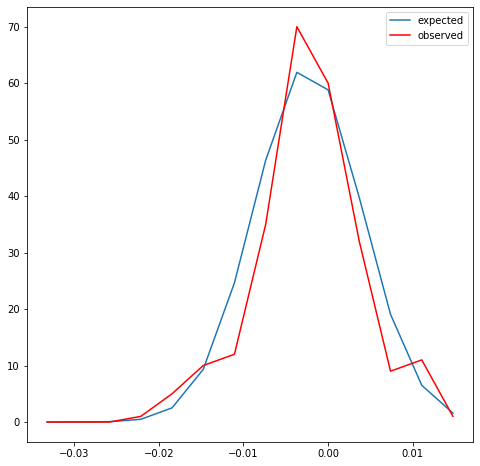

In [174]:
Hi2(DAX_logR,14)

Мы получили самое маленье значение Хи2 за все тесты по заданиям. 


И хотя графики очень близки и похожи, значение Хи2 для неотвержения гипотезы нормального распределения должно быть меньше.

В качестве своей модели мы бы рассматривали как среднее по доходности всех акций на рынке. Данная модель хороша тем, что она будет включать в себя не только самые "лучшие" то есть доходные компании, а большинство "средних" компаний будет держать индекс в более менее стабильном положении. Минус такого индеса в том, что если у нас будет много компаний, цены которых не меняются, или меняюся не сильно, величина индекса будет стремится к нулю. Хотя, можем заметить, что индекс DAX так же близок к нулю.

In [181]:
np.array(DAX_logR).mean()

-0.0004290836653386454

Величина нашего "равномерного" индекса. Заметим, что эта величина положительная и по модулю примерно равна величине DAX. 

In [184]:
(logR.mean()).mean()

0.0006437964729861408

## 5. Модель с одним индексом

$R_i = \alpha_i + \beta_i * R_m + \xi_i$, где $R_m$ доходность нашего индекса и через нее мы выражаем доходности других активов

In [187]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

Попробуем воспользоваться линейной регрессией для подбора альфа, бетта коэффициентов и ошибок 

In [188]:
oneFactor_stocks=portfolio_stocks[:10]

In [191]:
def searchCoef(stocks):
    coef=[]
    for i in range(len(stocks)):
        Xtrn, Xtest, Ytrn, Ytest = train_test_split(DAX_logR, logR[stocks[i]][0:251], test_size=0.1, shuffle=True, random_state=42)
        Ytrng=[]
        Xtrng=[]
        Xtes=[]
        for i in range(len( Ytrn)):
            Ytrng.append(Ytrn[i])
            a=[]
            a.append(1)
            a.append(Xtrn[i])
            a.append(1)
            Xtrng.append(a)
    
        for i in range(len( Ytest)):
            a=[]
            a.append(1)
            a.append(Xtest[i])
            a.append(1)
            Xtes.append(a)
        regr = LinearRegression(fit_intercept=True,copy_X=True)
        regr.fit(Xtrng, Ytrng)
        coef.append(regr.coef_)
    return coef

In [194]:
coef=searchCoef(oneFactor_stocks)
betta=[]
for i in range(len(coef)):
    betta.append(coef[i][1])
betta=np.array(betta)

У нас получается, что коэффициент альфа всегда равен нулю. Ведь мы знаем из формулы $R_i = \alpha_i + \beta_i * R_m + \xi_i$ мы знаем и наблюдаем величины 
$R_i$ и $R_m$. Поделив, мы получим бетта, и все остальные коэффициенты дадут ноль.

In [193]:
DAX_logR=np.array(DAX_logR)
E_m=DAX_logR.mean()
S_m=DAX_logR.std()

Функция, возвращающая риск и ожидаемый доход портфеля. Необходимо для построения оптимального.

In [290]:
def portfolioS2(xi_array):
    return sum(xi_array*betta)*S_m**2+((xi_array*betta*S_m)**2).mean()
def portfolioE(xi_array):
    return sum(xi_array*betta)*E_m

In [291]:
portfolioS2([0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1])

-1.7014486846337658e-05

Так как все коэффициенты $\alpha_i ,\xi_i$ равны нулю нет смысла проверять какую-либо коррелируемость. По данным результатам строить портфель тоже не представляется логичным. Скорее всего, где-то в наших начальных рассуждениях имеется ошибка и поэтому у нас неверно подбираются коэффициенты. К сожалению, ни в литературе, ни в статьях не разбирается как конкретно подбирать данные величины, обычно было написано "с помощью линейной регрессии". Мы поняли это имеено так. 